In [1]:
import os
import matplotlib.pyplot as plt

from scripts.pre_process_dataset import PreProcess
from scripts.import_dataset import ImportDataset
from scripts.plots import PlotReport

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 16

[nltk_data] Downloading package wordnet to /home/dip07/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/dip07/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = ImportDataset()
df = data.read_dataset()
print(f"✅ Combined dataset size: {df.shape[0]} samples")

✅ Combined dataset size: 14438 samples


In [3]:
clean_df = PreProcess(df)
df = clean_df.preprocess_dataset()
df.head(1)

,condition_label,medical_abstract
0,0,tissue change around loose prosthesis canine m...


In [4]:
tfidf = TfidfVectorizer(
    ngram_range=(1,2),     # capture meaningful medical phrases
    max_df=0.5,            # remove very common words
    min_df=5,              # ignore rare noise words
    sublinear_tf=True,     # scale term frequencies
    use_idf=True,          # emphasize rare informative terms
    max_features=3000      # limit to the most relevant terms
)
X = tfidf.fit_transform(df['medical_abstract'])
y = df['condition_label']

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_test.shape[0]}")
print(f"Test set size: {X_valid.shape[0]}")

Training set size: 10106
Validation set size: 2166
Test set size: 2166


In [6]:
accuracy_list = []
for i in range(1, 40, 2):
    knn = KNeighborsClassifier(n_neighbors=i, metric='cosine')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    accuracy_list.append(accuracy)

Max Accuracy: 0.6144967682363804
K: 29


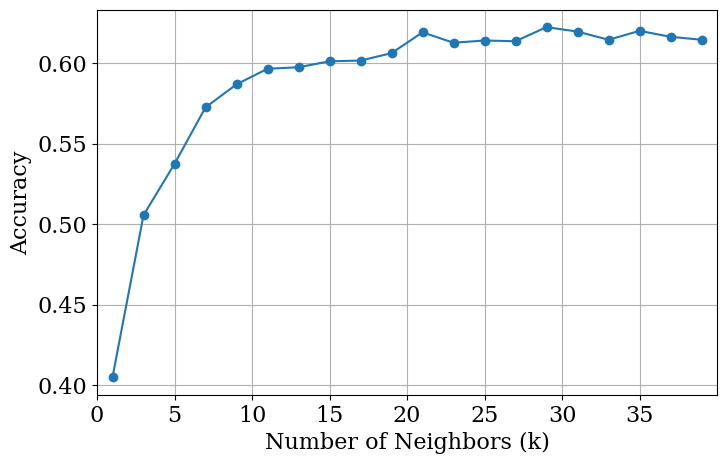

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(range(1,40, 2), accuracy_list, marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xticks(range(0,40, 5))
plt.xlim(0, 40)

print("Max Accuracy:", accuracy_score(y_valid, y_pred))
k = accuracy_list.index(max(accuracy_list)) * 2 + 1
print("K:", k)
plt.savefig(os.path.join("plots", "KNN_number_k_plot.pdf"), bbox_inches='tight')
plt.show()

In [8]:
knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=29)

In [9]:
knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
knn.fit(X_train, y_train)
# 
y_train_pred = knn.predict(X_train)
print("\n✅ Train Performance:")
print("Accuracy:", accuracy_score(y_train, y_train_pred))


✅ Train Performance:
Accuracy: 0.6462497526222046


In [10]:
knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
knn.fit(X_train, y_train)
# 
y_test_pred = knn.predict(X_test)
print("\n✅ Test Performance:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))


✅ Test Performance:
Accuracy: 0.6089566020313942



Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.48      0.52       753
           1       0.67      0.79      0.73       453
           2       0.48      0.45      0.47       209
           3       0.55      0.44      0.49       269
           4       0.65      0.80      0.72       482

    accuracy                           0.61      2166
   macro avg       0.59      0.59      0.59      2166
weighted avg       0.60      0.61      0.60      2166



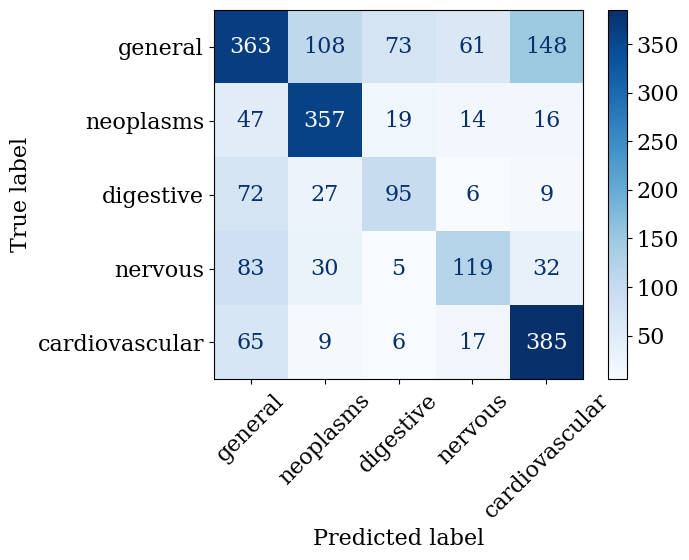

In [11]:
plot = PlotReport(knn, X_test, y_test)
plot.get_confusion_matrix()
plot.print_confusion_matrix("KNNConfusion.pdf")